## Tutorial DLPFC

Before running the model, please download the input data via: https://drive.google.com/drive/folders/1EzLhPeMaMA02fmZquNYwixMK0MSe7UAA?usp=drive_link

# 1. Environment Setup

In [1]:
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
from pandas import Categorical
import torch
from sklearn.mixture import GaussianMixture
from sklearn.metrics import pairwise_distances, adjusted_rand_score, normalized_mutual_info_score
import scanpy as sc
import cv2
from STMSC import utils,train,load_data_preprocess

warnings.filterwarnings("ignore")
device = torch.device('cuda:0')

# 2. Load and Preprocess Data

In [2]:
# spatial data
# slice_idx = [151507, 151508, 151509, 151510]
# slice_idx = [151669, 151670, 151671, 151672]
slice_idx = [151673, 151674, 151675, 151676]

anno_df = pd.read_csv('LIBD/barcode_level_layer_map.tsv', sep='\t', header=None)

adata_st1 = sc.read_visium(path="LIBD/%d" % slice_idx[0],
                        count_file="%d_filtered_feature_bc_matrix.h5" % slice_idx[0])
spatial1=pd.read_csv(os.path.join('LIBD', str(slice_idx[0]), "spatial/tissue_positions_list.txt"),sep=",",header=None,na_filter=False,index_col=0) 
anno_df1 = anno_df.iloc[anno_df[1].values.astype(str) == str(slice_idx[0])]
anno_df1.columns = ["barcode", "slice_id", "layer"]
anno_df1.index = anno_df1['barcode']
adata_st1.obs = adata_st1.obs.join(anno_df1, how="left")
adata_st1.obs["x_pixel"]=spatial1[4]
adata_st1.obs["y_pixel"]=spatial1[5]
adata_st1 = adata_st1[adata_st1.obs['layer'].notna()]


adata_st2 = sc.read_visium(path="LIBD/%d" % slice_idx[1],
                        count_file="%d_filtered_feature_bc_matrix.h5" % slice_idx[1])
spatial2=pd.read_csv(os.path.join('LIBD', str(slice_idx[1]), "spatial/tissue_positions_list.txt"),sep=",",header=None,na_filter=False,index_col=0) 
anno_df2 = anno_df.iloc[anno_df[1].values.astype(str) == str(slice_idx[1])]
anno_df2.columns = ["barcode", "slice_id", "layer"]
anno_df2.index = anno_df2['barcode']
adata_st2.obs = adata_st2.obs.join(anno_df2, how="left")
adata_st2.obs["x_pixel"]=spatial2[4]
adata_st2.obs["y_pixel"]=spatial2[5]
adata_st2 = adata_st2[adata_st2.obs['layer'].notna()]

adata_st3 = sc.read_visium(path="LIBD/%d" % slice_idx[2],
                        count_file="%d_filtered_feature_bc_matrix.h5" % slice_idx[2])
spatial3=pd.read_csv(os.path.join('LIBD', str(slice_idx[2]), "spatial/tissue_positions_list.txt"),sep=",",header=None,na_filter=False,index_col=0) 
anno_df3 = anno_df.iloc[anno_df[1].values.astype(str) == str(slice_idx[2])]
anno_df3.columns = ["barcode", "slice_id", "layer"]
anno_df3.index = anno_df3['barcode']
adata_st3.obs = adata_st3.obs.join(anno_df3, how="left")
adata_st3.obs["x_pixel"]=spatial3[4]
adata_st3.obs["y_pixel"]=spatial3[5]
adata_st3 = adata_st3[adata_st3.obs['layer'].notna()]

adata_st4 = sc.read_visium(path="LIBD/%d" % slice_idx[3],
                        count_file="%d_filtered_feature_bc_matrix.h5" % slice_idx[3])
spatial4=pd.read_csv(os.path.join('LIBD', str(slice_idx[3]), "spatial/tissue_positions_list.txt"),sep=",",header=None,na_filter=False,index_col=0) 
anno_df4 = anno_df.iloc[anno_df[1].values.astype(str) == str(slice_idx[3])]
anno_df4.columns = ["barcode", "slice_id", "layer"]
anno_df4.index = anno_df4['barcode']
adata_st4.obs = adata_st4.obs.join(anno_df4, how="left")
adata_st4.obs["x_pixel"]=spatial3[4]
adata_st4.obs["y_pixel"]=spatial3[5]
adata_st4 = adata_st4[adata_st4.obs['layer'].notna()]

adata_st_list_raw = [adata_st1, adata_st2, adata_st3, adata_st4]
#Read in hitology image
img1=cv2.imread(os.path.join('LIBD/', str(slice_idx[0]), str(slice_idx[0])+"_full_image.tif"))
img2=cv2.imread(os.path.join('LIBD/', str(slice_idx[1]), str(slice_idx[1])+"_full_image.tif"))
img3=cv2.imread(os.path.join('LIBD/', str(slice_idx[2]), str(slice_idx[2])+"_full_image.tif"))
img4=cv2.imread(os.path.join('LIBD/', str(slice_idx[3]), str(slice_idx[3])+"_full_image.tif"))
adata_img_list_raw = [img1, img2, img3, img4]

In [3]:
load_data_preprocess.extract_histology_features(adata_st_list_raw, adata_img_list_raw)
utils.set_seed(2024)
adata_st_list = load_data_preprocess.align_spots(adata_st_list_raw, plot=False)
adata_ref = sc.read_h5ad('LIBD/human_MTG_snrna_norm_by_exon.h5ad')
adata_ref.obs['celltype'] = adata_ref.obs['cluster_label']
adata_st, adata_basis, _ = load_data_preprocess.preprocess(
    adata_st_list, adata_ref,
    sample_col=None,
    n_hvg_group=500
)
adata_st_list = load_data_preprocess.align_spots_3D(adata_st_list_raw)
adata_st.obsm['spatial_aligned'] = np.vstack([np.array(lst) for a in adata_st_list for lst in a.obsm['spatial_aligned']])


Using the Iterative Closest Point algorithm for alignemnt.
Detecting edges...
Aligning edges...
Finding highly variable genes...
8062 highly variable genes selected.
Calculate basis for deconvolution...
Preprocess ST data...
Start building a graph...
Radius for graph connection is 150.7000.
9.8415 neighbors per cell on average.
Using the Iterative Closest Point algorithm for alignment.
Detecting edges...
Aligning edges...


# 3.Learn map matrix

In [4]:
map = train.learn_mapping_matrix(adata_st, adata_basis, lam=7, epoch=5000)
np.save('map_673_lam_7.npy', map)

100%|██████████| 5000/5000 [1:51:14<00:00,  1.33s/it]


# 4. Spatial Graph Construction

In [5]:
adata_st.obsm["graph"] = utils.construct_combined_graph(
    adata_st=adata_st,
    loc_3D=adata_st.obsm['spatial_aligned'],
    map_path='map_673_lam_7.npy',
    bl=0.1,
    bll=0.1
)

# 5. Train STMSC Model

In [6]:
model, latent = train.train_stmsc_model(adata_st, adata_basis, device=device,epochs=5000)

100%|██████████| 5000/5000 [12:06<00:00,  6.88it/s]


# 6. Domain Identification

In [7]:
gm = GaussianMixture(n_components=7, covariance_type='tied', init_params='kmeans')
pred_labels = gm.fit_predict(latent)
pred_labels = Categorical(pred_labels)

splits = [a.shape[0] for a in adata_st_list_raw]
idxs = np.cumsum([0] + splits)
for i in range(4):
    true = adata_st_list_raw[i].obs['layer']
    pred = pred_labels[idxs[i]:idxs[i+1]]
    print(f'Slice {i}, ARI = {adjusted_rand_score(true, pred):.4f}, NMI = {normalized_mutual_info_score(true, pred):.4f}')

print(f'Total ARI = {adjusted_rand_score(adata_st.obs["layer"], pred_labels):.4f}')
print(f'Total NMI = {normalized_mutual_info_score(adata_st.obs["layer"], pred_labels):.4f}')

Slice 0, ARI = 0.5749, NMI = 0.7121
Slice 1, ARI = 0.6319, NMI = 0.7458
Slice 2, ARI = 0.5611, NMI = 0.7047
Slice 3, ARI = 0.5998, NMI = 0.7156
Total ARI = 0.5875
Total NMI = 0.7076


# 7. Visualization

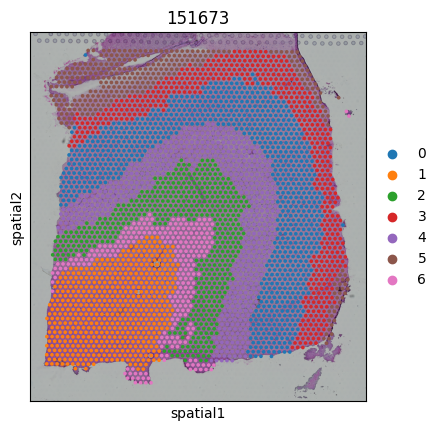

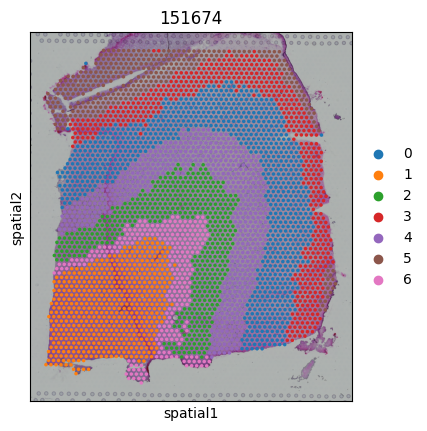

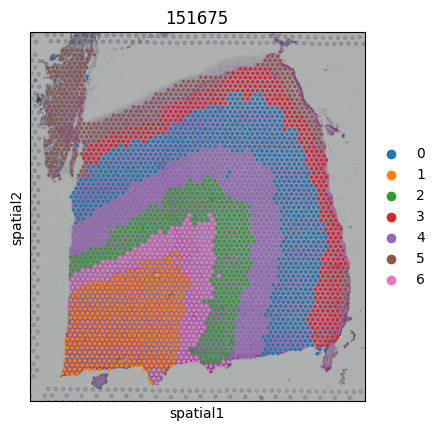

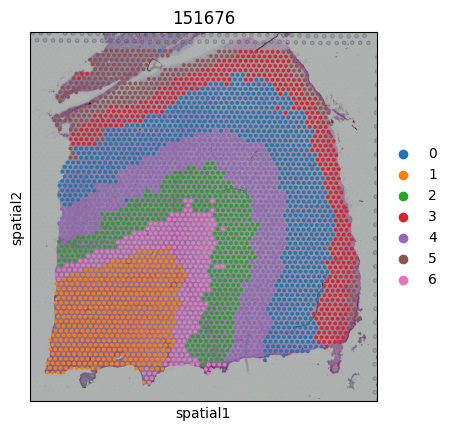

In [8]:
for i,adata_sub in enumerate(adata_st_list):
    pred = pred_labels[idxs[i]:idxs[i+1]]
    adata_sub.obs['Region'] = pred
    sc.pl.spatial(adata_sub,color=["Region"],title=str(slice_idx[i]))